In [1]:
import gym
import os
import numpy as np
import random 
from collections import namedtuple, deque 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Rendering OpenAi env in colab


In [3]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [4]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import shutil 

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video(save_dir_name):
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    print(mp4list)
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
    #source = mp4list[0]
    #print(source)
    #dest = save_dir_name
    #dest = shutil.move(source, dest)
    

  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Rand Agent - Mountain Car -continuous

In [ ]:
#### Developing a random agent for 

MC_env = wrap_env(gym.make('MountainCarContinuous-v0'))


### Exploring the env
print('State Space of the MC env : ',MC_env.observation_space)
print('Action Space of the MC env : ',MC_env.action_space)


### EXtents of the state space 
print('Low extent of MC env', MC_env.observation_space.low )
print('High extent of MC env', MC_env.observation_space.high)

print('Low extent of MC env', MC_env.action_space.low )
print('High extent of MC env', MC_env.action_space.high)


# Initializing a random agent...

class RandAgent():
  def __init__(self,env):
    self.env = env
    pass
  def take_action(self):
    action = self.env.action_space.sample()
    return action

randAgent = RandAgent(MC_env)
MC_env.reset()
print(type(MC_env.state) )
done  = False
steps = 0

while not done :

  action = randAgent.take_action()
  print(action)
  obs, rew, done, info = MC_env.step(action)
  steps += 1
  
  print('Step {} --> action {} --> reward {} --> position {:.2f} , vel {:.2f}'.format(steps,action, rew, obs[0], obs[1]))

MC_env.close()
show_video('/content/video')



State Space of the MC env :  Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Action Space of the MC env :  Box(-1.0, 1.0, (1,), float32)
Low extent of MC env [-1.2  -0.07]
High extent of MC env [0.6  0.07]
Low extent of MC env [-1.]
High extent of MC env [1.]
<class 'numpy.ndarray'>
[0.7732918]
Step 1 --> action [0.7732918] --> reward -0.05979802485422284 --> position -0.42 , vel 0.00
[-0.63634205]
Step 2 --> action [-0.63634205] --> reward -0.04049312028737404 --> position -0.42 , vel -0.00
[0.99164265]
Step 3 --> action [0.99164265] --> reward -0.09833551531173478 --> position -0.42 , vel -0.00
[0.72566575]
Step 4 --> action [0.72566575] --> reward -0.052659077799362214 --> position -0.42 , vel -0.00
[0.50315064]
Step 5 --> action [0.50315064] --> reward -0.0253160568462679 --> position -0.42 , vel -0.00
[-0.9679585]
Step 6 --> action [-0.9679585] --> reward -0.0936943676930472 --> position -0.42 , vel -0.00
[0.65645486]
Step 7 --> action [0.65645486] --> reward -0.043093

# Observations

The action space is a single dim vector ranging between (-1,1). Receives a reward of 100 if we reach the other end

# DDPG

In [5]:
#### Model architecutures ..
'''
We need 4 networks a target network and the not the target net
1. A CNet s,a--> Q(s,a)
2. A ANet : s--> a
'''

class ActorNet(nn.Module):
  
  def __init__(self, state_size, action_size, seed,fc1_size = 64, fc2_size= 64):
    super(ActorNet,self).__init__() ## init parent class nn.module
    self.seed= torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size,fc1_size)
    self.fc2= nn.Linear(fc1_size,fc2_size)
    self.out= nn.Linear(fc2_size, action_size)

  def forward(self,s):
    '''
    s --> state vector
    '''
    s = F.relu(self.fc1(s))
    s = F.relu(self.fc2(s))
    return torch.tanh(self.out(s))  ### TODO : need to change as per bouds of values of actions


class CriticNet(nn.Module):

  def __init__(self,state_size, action_size,out_size , seed,fc1_size = 64, fc2_size= 64):
    ## inp size shd be state_size + action _size
    super(CriticNet,self).__init__()
    self.seed= torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size + action_size,fc1_size)
    self.fc2= nn.Linear(fc1_size,fc2_size)
    self.out= nn.Linear(fc2_size, out_size)

  def forward(self,s,a):
    '''
    s --> state vector
    '''
    inp = torch.cat([s,a],1)
    inp = F.relu(self.fc1(inp))
    inp = F.relu(self.fc2(inp))
    return self.out(inp)  ### TODO : need to change as per bouds of values of actions

In [6]:
'''
Replay buffer initialising ... same as DQN
'''

#### Replay buffer architechture...
class ReplayBuffer(object):
  '''
  Contains transitions represented as tuples (s,a,r,s',done)
  '''

  def __init__(self, action_size,buffer_size, batch_size, seed, device):
    '''

    '''
    self.buffer = deque(maxlen = buffer_size)
    self.action_size = action_size
    self.batch_size = batch_size
    self.seed = random.seed(seed)
    self.transition = namedtuple("Transition", field_names = ['s','a','r','ns','done'])

  def __len__(self):
    return len(self.buffer)

    
  def add(self, state, action, reward,next_state,done):
    '''
    Adds a transition tuple to the buffer
    '''
    t = self.transition(state, action, reward,next_state,done)
    self.buffer.append(t) ### Adding the transition to the buffer

  def sample(self):
    '''
    Randomly sample batch_size transitions' from the replay buffer  
    '''

    t_bs = random.sample(self.buffer, k = self.batch_size) ## transition batch size
    states = (torch.from_numpy(np.vstack([t.s for t in t_bs if t is not None])).float()).to(device)
    actions = torch.from_numpy(np.vstack([t.a for t in t_bs if t is not None])).float().to(device)
    rewards = torch.from_numpy(np.vstack([t.r for t in t_bs if t is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([t.ns for t in t_bs if t is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([t.done for t in t_bs if t is not None])).float().to(device) ## converts bool to float 
    
    return (states, actions, rewards, next_states, dones)


In [7]:
#### defining stochastic noise   ... TODO

class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0): 
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)#,ou_state


class GaussianNoise(object):
  def __init__(self, action_space, mu = 0,sig = 0.25):
    self.mu = mu
    self.sigma = sig
    self.action_dim   = action_space.shape[0]
    self.low          = action_space.low
    self.high         = action_space.high

  def reset(self):
    self.state = np.ones(self.action_dim)*self.mu

  def get_action(self,action,t = 0):
    n = np.random.normal(self.mu, self.sigma, self.action_dim)
  
    return np.clip(action + n, self.low, self.high)#,n

'''
Testing

env = gym.make('MountainCarContinuous-v0')
#noise = OUNoise(env.action_space)
noise = GaussianNoise(env.action_space,mu=0,sig=0)



env.reset()
done  = False
steps = 0

while not done :

  action = env.action_space.sample()
  noisy_action = noise.get_action(action)
  print(action, noisy_action)
  obs, rew, done, info = env.step(action)  
  steps += 1

env.close()
'''

"\nTesting\n\nenv = gym.make('MountainCarContinuous-v0')\n#noise = OUNoise(env.action_space)\nnoise = GaussianNoise(env.action_space,mu=0,sig=0)\n\n\n\nenv.reset()\ndone  = False\nsteps = 0\n\nwhile not done :\n\n  action = env.action_space.sample()\n  noisy_action = noise.get_action(action)\n  print(action, noisy_action)\n  obs, rew, done, info = env.step(action)  \n  steps += 1\n\nenv.close()\n"

In [8]:
class DDPGAgent(object):
  '''
  Agent trained using DDPG algo
  '''

  def __init__(self,env ,seed, device, 
               BUFFER_SIZE = 50000,
               BATCH_SIZE = 512,
               GAMMA = 0.99,
               ANet_LR =1e-4 ,
               CNet_LR = 1e-4,
               TAU = 1e-2):
  
    self.state_size = env.observation_space.shape[0]
    self.action_size = env.action_space.shape[0]
    self.seed = random.seed(seed)

    self.BUFFER_SIZE = BUFFER_SIZE
    self.BATCH_SIZE = BATCH_SIZE
    self.GAMMA = GAMMA
    self.ANet_LR =  ANet_LR
    self.CNet_LR =  CNet_LR
    self.TAU = TAU
    self.device= device

    #### Init networks and target nets 
    self.ANet = ActorNet(self.state_size,self.action_size,seed).to(self.device)
    self.ANet_target =  ActorNet(self.state_size,self.action_size,seed).to(self.device)

    self.CNet =  CriticNet(self.state_size, self.action_size, self.action_size,seed).to(self.device) ### output size is same as action size
    self.CNet_target = CriticNet(self.state_size, self.action_size, self.action_size,seed).to(self.device) ### output size is same as action size

    ##  init target nets with orig nets

    for target_param, local_param in zip(self.ANet_target.parameters(), self.ANet.parameters()):
      target_param.data.copy_(local_param.data)

    for target_param, local_param in zip(self.CNet_target.parameters(), self.CNet.parameters()):
      target_param.data.copy_(local_param.data)

    ### optimizers
    self.ANet_optim = optim.Adam(self.ANet.parameters(), lr = self.ANet_LR)
    self.CNet_optim = optim.Adam(self.CNet.parameters(), lr = self.CNet_LR)

    ## Init buffer 
    self.RB = ReplayBuffer(self.action_size, self.BUFFER_SIZE, self.BATCH_SIZE,seed, self.device)


  def act(self, state):
    '''
    returns action for a given state 
    '''

    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device) # unsqueeze to add the batch dim
    self.ANet.eval() ## putting in inference mode
    
    with torch.no_grad():
      action_val = self.ANet.forward(state)
    self.ANet.train()

    return action_val

  def step(self,s,a,r,ns,d):
    '''
    if buffer > batch size , then sample from it and learn
    '''

    self.RB.add(s,a,r,ns,d)
    if(len(self.RB) > self.BATCH_SIZE):
      transition = self.RB.sample()
      self.learn(transition)

  def learn(self, t_bs): ## t_bs refers to transitions of a batch
    s_bs,a_bs,r_bs, ns_bs, d_bs = t_bs

    self.CNet_criterion = nn.MSELoss()

    ### finding critic loss
    Q_pred = self.CNet.forward(s_bs,a_bs)

    ### finding Q_labels
    na_bs = (self.ANet_target.forward(ns_bs)).detach() ## use detach to exclude ANet from graph
    #na_bs = na_bs.detach()
    nq_bs = (self.CNet_target.forward(ns_bs,na_bs)).detach() ## dont use CNet from 
    Q_label = r_bs + self.GAMMA*(nq_bs)
    CNet_loss = self.CNet_criterion(Q_pred, Q_label)

    ### Actor loss
    ## Although we have the policy gradient .. we simply want to increase the mean Q_val for the actions taken
    ANet_loss = -1*(self.CNet.forward(s_bs, self.ANet.forward(s_bs)).mean())

    ### Update nets
    self.ANet_optim.zero_grad()
    ANet_loss.backward()
    self.ANet_optim.step()

    self.CNet_optim.zero_grad()
    CNet_loss.backward()
    self.CNet_optim.step()

    for target_param, local_param in zip(self.ANet_target.parameters(), self.ANet.parameters()):
      target_param.data.copy_(self.TAU*(local_param.data) + (1-self.TAU)*(target_param))

    for target_param, local_param in zip(self.CNet_target.parameters(), self.CNet.parameters()):
      target_param.data.copy_(self.TAU*(local_param.data) + (1-self.TAU)*(target_param))

  def train_agent(self,env,
                  save_dir_name,
                  n_episodes = 100,
                  TARGET_SCORE = -200, ## Min score required for saving the best model,
                  SCORE_WINDOW_LEN = 100, ## Min score required for saving the best model,
                  noise_type = 'OU'
                  ):
    
    if(noise_type=='OU'):
      noise = OUNoise(env.action_space)
    elif(noise_type == "GAUSS"):
      noise = GaussianNoise(env.action_space)


    '''
    n_epi : no. of traninin episodes
    eps_str, eps_end, eps_decay: param of eps exploration: going from random to full greedy
    TARGET_SCORE: min score required to start saving the model
    SCORE_WINDOW_LEN: len of deque storing prev episode scores.. for plotting training curve
    '''
    ##### Writing results in a txt file for further reference..
    f= open( save_dir_name + "/train_log.txt","a")
    f.write("\nHYPERPARAMETERS\n")
    comment = str(input('Enter a comment..'))
    f.write('Comment: {}\n'.format(comment) )
    f.write("\n-------------------\n")
    f.write('BUFFER_SIZE: {}\n'.format(self.BUFFER_SIZE))
    f.write('BATCH_SIZE: {}\n'.format(self.BATCH_SIZE))
    f.write('GAMMA: {}\n'.format(self.GAMMA))
    f.write('NOISE TYPE: {}\n'.format(noise_type))
    f.write('CNet_LR: {}\n'.format(self.CNet_LR))
    f.write('ANet_LR: {}\n'.format(self.ANet_LR))
    f.write('SEED: {}\n'.format(self.seed))


    f.write("-------------------")
    f.write("TRAIN PARAMETERS")
    f.write("-------------------\n")
    f.write('n_episodes: {}\n'.format(n_episodes))
    f.write('SCORE_WINDOW_LEN: {}\n'.format(SCORE_WINDOW_LEN))
    f.write('device: {}\n'.format(device))
    f.write('TARGET_SCORE: {}\n'.format(TARGET_SCORE))
    f.write("-------------------")
    f.write("TRAINING")
    f.write("-------------------\n")

    ###########################################################################3
    ### TRAINING....

    scores = [] ## list containing score from each episode
    scores_window = deque(maxlen = SCORE_WINDOW_LEN)

    ### plotting vars
    episodes = []
    avg_scores = []

    for i_epi in range(1, n_episodes):
      self.t_step=0
      state = env.reset()
      done = 0
      score = 0

      while not done:
        action = self.act(state).cpu().data.numpy()
        
        noisy_action = noise.get_action(action,self.t_step)[0] ## since output comes in [[]] format
        
        next_state,reward,done,_ = env.step( noisy_action)
        self.step(state,action,reward,next_state, done)
        state = next_state
        score += reward

        self.t_step = self.t_step+1
        

      scores.append(score)## save the most recent score
      scores_window.append(score)

      avg_score = np.mean(scores_window)
      print('\rEpisode {}\tAverage Score {:.2f}'.format(i_epi,avg_score), end="")

      if(i_epi %10 ==0):
        print('\rEpisode {}\tAverage Score {:.2f}'.format(i_epi, avg_score ))
        f= open( save_dir_name + "/train_log.txt","a")
        f.write('\rEpisode {}\ttime_step {}\tAverage Score {:.2f}'.format(i_epi,self.t_step,avg_score))
        episodes.append(i_epi)
        avg_scores.append(avg_score)

      if(avg_score >= TARGET_SCORE):
        print('\nEnvironment solve in {:d} epsiodes!\tAverage score: {:.2f}'.format(i_epi, avg_score ))
        TARGET_SCORE = avg_score
        torch.save(self.CNet.state_dict(),save_dir_name + '/best_CNet.pth')
        torch.save(self.CNet_target.state_dict(),save_dir_name + '/best_CNet_target.pth')

        torch.save(self.ANet.state_dict(),save_dir_name + '/best_ANet.pth')
        torch.save(self.ANet_target.state_dict(),save_dir_name + '/best_ANet_target.pth') 

        print("BEST Created!!")

      ### Saving final networks
      torch.save(self.CNet.state_dict(),save_dir_name + '/last_CNet.pth')
      torch.save(self.CNet_target.state_dict(),save_dir_name + '/last_CNet_target.pth')

      torch.save(self.ANet.state_dict(),save_dir_name + '/last_ANet.pth')
      torch.save(self.ANet_target.state_dict(),save_dir_name + '/last_ANet_target.pth') 

      ### Plotting learning curves
      plt.plot(episodes, avg_scores)
      plt.xlabel('episodes')
      plt.ylabel('mean-{} episode reward'.format(SCORE_WINDOW_LEN))
      plt.title('DDPG Agent training')
      plt.savefig(save_dir_name + '/train_plot.png')




In [9]:
#### Utilities ...

def find_model_dir_title(dir_path, continue_training):
  '''
  Given a dir where all exp are stored .. finds the last dir and creates a name for the new dir
  If we want to continur training it finds the latest directory and intialises the model with last tranined models
  '''
  print('I got ',continue_training)
  dir_len = sum(os.path.isdir(dir_path +'/'+ i) for i in  os.listdir(dir_path))

  if(continue_training==1):
    dir_len = dir_len -1
  return dir_path + '/exp'+str(dir_len)

# DDPG Agent for MCar-Continuous

In [ ]:
continue_training = int(input('continue_training..?'))

### finding save dir path...
dir_path =  '/content/drive/MyDrive/RL_implementations/Mountain_Car_Cont/DDPG'
save_dir_name = find_model_dir_title(dir_path, continue_training)

if(continue_training==0):
  print('Created\t',save_dir_name )
  os.mkdir(save_dir_name)

continue_training..?0
I got  0
Created	 /content/drive/MyDrive/RL_implementations/Mountain_Car_Cont/DDPG/exp8


In [ ]:
### Setup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MC_env = gym.make('MountainCarContinuous-v0')

DDPG_agent = DDPGAgent(env = MC_env,
                       seed = 0,
                       device = device,
                       BUFFER_SIZE = 50000,
                       BATCH_SIZE = 128,
                       GAMMA = 0.99,
                       ANet_LR =0.0001 ,
                       CNet_LR = 0.0005,
                       TAU = 0.01
                       )


if(continue_training==1):
    print("Continue from previous model ...")

    DDPG_agent.CNet.load_state_dict(torch.load(save_dir_name + '/last_CNet.pth'))
    DDPG_agent.CNet_target.load_state_dict(torch.load(save_dir_name + '/last_CNet_target.pth'))

    DDPG_agent.ANet.load_state_dict(torch.load(save_dir_name + '/last_ANet.pth'))
    DDPG_agent.ANet_target.load_state_dict(torch.load(save_dir_name + '/last_ANet_target.pth'))


Enter a comment..gauss'
Episode 10	Average Score -6.60
Episode 20	Average Score -6.47
Episode 30	Average Score -6.43
Episode 40	Average Score -6.42
Episode 50	Average Score -6.41
Episode 60	Average Score -6.39
Episode 70	Average Score -6.41
Episode 80	Average Score -6.41
Episode 90	Average Score -6.42
Episode 99	Average Score -6.41

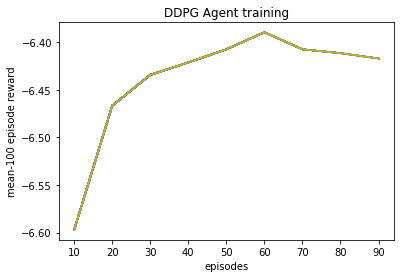

In [ ]:
DDPG_agent.train_agent(env = MC_env,
                       save_dir_name = save_dir_name ,
                       n_episodes = 100,
                       TARGET_SCORE = 50,
                       SCORE_WINDOW_LEN = 100,
                       noise_type = 'GAUSS')

In [ ]:
#### Inference and rendering the best player
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MC_env = wrap_env(gym.make('MountainCarContinuous-v0'))
trained_agent = DDPG_agent = DDPGAgent(env = MC_env,
                       seed = 0,
                       device = device,)
save_dir_name = '/content/drive/MyDrive/RL_implementations/Mountain_Car_Cont/DDPG/exp4'

trained_agent.CNet.load_state_dict(torch.load(save_dir_name + '/best_CNet.pth'))
trained_agent.CNet_target.load_state_dict(torch.load(save_dir_name + '/best_CNet_target.pth'))

trained_agent.ANet.load_state_dict(torch.load(save_dir_name + '/best_ANet.pth'))
trained_agent.ANet_target.load_state_dict(torch.load(save_dir_name + '/best_ANet_target.pth'))



MC_env.reset()

obs = MC_env.state
done  = False
steps = 0

while not done :
  action = trained_agent.act(obs)[0]
  obs, rew, done, info = MC_env.step(action.cpu())
  steps += 1

MC_env.close()
show_video(save_dir_name)

['video/openaigym.video.3.5683.video000000.mp4']


# Learning curves

a) DDPG :  with OU Noise 

hyper param of Noise #

mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000

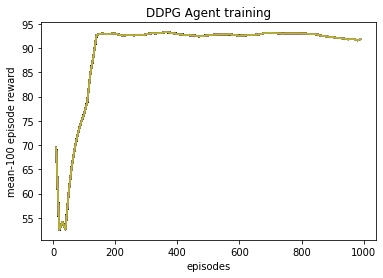

b) DDPG: with gaussian noise
nu = 0, sig = 0.25

 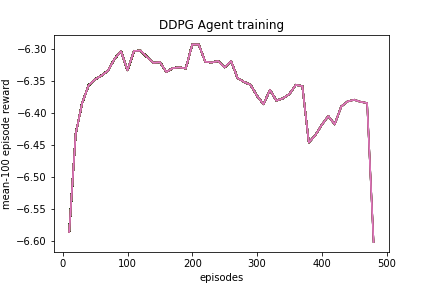

# Observations 

We can observe that the DDPG agent when exposed to Gaussian Noise learns slowly , as slowly that it merely improves in it .

OU Noise is correlated with the noise generated in the previous time steps thus makes sense when used in the continuous action space setting , because a completely random action out of no where might be very absurd even in a stochastic environment setting .

#  LunarRover continuous

In [ ]:
'''
Resource to install lunar lander
https://stackoverflow.com/questions/64161280/rl-problem-on-colab-for-gym-envs-box2d-has-no-attribute-lunarlander
'''
!pip3 install box2d-py
!pip3 install gym[Box_2D]

     |████████████████████████████████| 448 kB 9.1 MB/s 


## Exploring the environment

In [4]:

LL_env = gym.make('LunarLanderContinuous-v2')
LL_env.reset()

### Exploring the env
print('State Space of the LL env : ',LL_env.observation_space)
print('Action Space of the LL env : ',LL_env.action_space)

### EXtents of the state space 
print('Low extent of LL env', LL_env.observation_space.low )
print('High extent of LL env', LL_env.observation_space.high)

## Of action spaces ...
print('Low extent of LL env', LL_env.action_space.low )
print('High extent of LL env', LL_env.action_space.high)
"""
s (list): The state. Attributes:
        s[0] is the horizontal coordinate
        s[1] is the vertical coordinate
        s[2] is the horizontal speed
        s[3] is the vertical speed
        s[4] is the angle
        s[5] is the angular speed
        s[6] 1 if first leg has contact, else 0
        s[7] 1 if second leg has contact, else 0
returns:
a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

State Space of the LL env :  Box(-inf, inf, (8,), float32)
Action Space of the LL env :  Box(-1.0, 1.0, (2,), float32)
Low extent of LL env [-inf -inf -inf -inf -inf -inf -inf -inf]
High extent of LL env [inf inf inf inf inf inf inf inf]
Low extent of LL env [-1. -1.]
High extent of LL env [1. 1.]


'\ns (list): The state. Attributes:\n        s[0] is the horizontal coordinate\n        s[1] is the vertical coordinate\n        s[2] is the horizontal speed\n        s[3] is the vertical speed\n        s[4] is the angle\n        s[5] is the angular speed\n        s[6] 1 if first leg has contact, else 0\n        s[7] 1 if second leg has contact, else 0\nreturns:\na: The heuristic to be fed into the step function defined above to determine the next step and reward.\n    '

## Developing a random agent for mountain car continuous-V2

In [12]:
#### Developing a random agent for 

LL_env = wrap_env(gym.make('LunarLanderContinuous-v2'))

# Initializing a random agent...

class RandAgent():
  def __init__(self,env):
    self.env = env
    pass
  def take_action(self):
    action = self.env.action_space.sample()
    return action

randAgent = RandAgent(LL_env)
LL_env.reset()
#print(type(LL_env.state) )
done  = False
steps = 0

while not done :

  action = randAgent.take_action()
  print(action)
  obs, rew, done, info = LL_env.step(action)
  steps += 1
  
  print('Step {} --> action {} --> reward {} --> position {:.2f} , vel {:.2f}'.format(steps,action, rew, obs[0], obs[1]))

LL_env.close()
show_video('/content/video')



[ 0.8544076  -0.81409734]
Step 1 --> action [ 0.8544076  -0.81409734] --> reward 2.3720804742514385 --> position -0.01 , vel 1.40
[-0.27730018 -0.06213833]
Step 2 --> action [-0.27730018 -0.06213833] --> reward -1.529222480462522 --> position -0.01 , vel 1.39
[-0.53357476 -0.9114574 ]
Step 3 --> action [-0.53357476 -0.9114574 ] --> reward -2.351104401884245 --> position -0.02 , vel 1.38
[ 0.26076862 -0.34741437]
Step 4 --> action [ 0.26076862 -0.34741437] --> reward -0.4455446147663338 --> position -0.02 , vel 1.37
[0.27352777 0.42697638]
Step 5 --> action [0.27352777 0.42697638] --> reward 0.802450993441471 --> position -0.03 , vel 1.37
[-0.60555637  0.3100434 ]
Step 6 --> action [-0.60555637  0.3100434 ] --> reward -1.7500277900741708 --> position -0.03 , vel 1.36
[0.9953098 0.9215445]
Step 7 --> action [0.9953098 0.9215445] --> reward 0.6925755156371804 --> position -0.03 , vel 1.35
[ 0.16856562 -0.8559271 ]
Step 8 --> action [ 0.16856562 -0.8559271 ] --> reward 0.41553198246851825 

# Observations

Receives a reward of 100 when we reach the destination between the flags. The action space consists of 2 dim , one controls the main engine while the other the direction of both left and right engines

## Training Lunar Lander using DDPG algorithm with OU noise exploration

In [13]:
continue_training = int(input('continue_training..?'))

### finding save dir path...
dir_path =  '/content/drive/MyDrive/RL_implementations/LunarLander_Cont-V2/DDPG'
save_dir_name = find_model_dir_title(dir_path, continue_training)

if(continue_training==0):
  print('Created\t',save_dir_name )
  os.mkdir(save_dir_name)

continue_training..?1
I got  1


In [14]:
### Setup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LL_env = gym.make('LunarLanderContinuous-v2')

DDPG_agent = DDPGAgent(env = LL_env,
                       seed = 0,
                       device = device,
                       BUFFER_SIZE = 50000,
                       BATCH_SIZE = 128,
                       GAMMA = 0.99,
                       ANet_LR = 1e-4 ,
                       CNet_LR = 1e-3,
                       TAU = 0.0001
                       )


if(continue_training==1):
    print("Continue from previous model ...")

    DDPG_agent.CNet.load_state_dict(torch.load(save_dir_name + '/last_CNet.pth'))
    DDPG_agent.CNet_target.load_state_dict(torch.load(save_dir_name + '/last_CNet_target.pth'))

    DDPG_agent.ANet.load_state_dict(torch.load(save_dir_name + '/last_ANet.pth'))
    DDPG_agent.ANet_target.load_state_dict(torch.load(save_dir_name + '/last_ANet_target.pth'))


Continue from previous model ...


Enter a comment..continuing
Episode 1	Average Score -55.61
Environment solve in 1 epsiodes!	Average score: -55.61
BEST Created!!
Episode 2	Average Score 9.14
Environment solve in 2 epsiodes!	Average score: 9.14
BEST Created!!
Episode 10	Average Score -160.79
Episode 20	Average Score -179.95
Episode 30	Average Score -198.96
Episode 40	Average Score -197.08
Episode 50	Average Score -215.74
Episode 60	Average Score -217.61
Episode 70	Average Score -208.58
Episode 80	Average Score -203.81
Episode 90	Average Score -203.09
Episode 100	Average Score -205.40
Episode 110	Average Score -204.68
Episode 120	Average Score -205.88
Episode 130	Average Score -199.30
Episode 140	Average Score -198.92
Episode 150	Average Score -187.17
Episode 160	Average Score -184.30
Episode 170	Average Score -187.08
Episode 180	Average Score -188.54
Episode 190	Average Score -182.88
Episode 200	Average Score -175.62
Episode 210	Average Score -177.25
Episode 220	Average Score -169.30
Episode 230	Average Score -165.47
E

KeyboardInterrupt: ignored

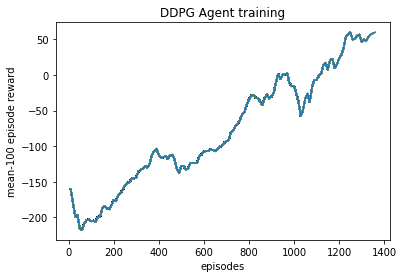

In [15]:
DDPG_agent.train_agent(env = LL_env,
                       save_dir_name = save_dir_name ,
                       n_episodes = 5000,
                       TARGET_SCORE = -600,
                       SCORE_WINDOW_LEN = 100,
                       noise_type = 'OU')

# Inference and video of agent playing

In [13]:
#### Inference and rendering the best player
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LL_env = wrap_env(gym.make('LunarLanderContinuous-v2'))
trained_agent = DDPG_agent = DDPGAgent(env = LL_env,
                       seed = 0,
                       device = device,)
save_dir_name = '/content/drive/MyDrive/RL_implementations/LunarLander_Cont-V2/DDPG/exp3'

trained_agent.CNet.load_state_dict(torch.load(save_dir_name + '/last_CNet.pth'))
trained_agent.CNet_target.load_state_dict(torch.load(save_dir_name + '/last_CNet_target.pth'))

trained_agent.ANet.load_state_dict(torch.load(save_dir_name + '/last_ANet.pth'))
trained_agent.ANet_target.load_state_dict(torch.load(save_dir_name + '/last_ANet_target.pth'))



LL_env.reset()

obs = LL_env.reset()
done  = False
steps = 0

while not done :
  action = trained_agent.act(obs)[0]
  print(action)
  obs, rew, done, info = LL_env.step(action.cpu().detach().numpy())
  steps += 1

  print('Step {} --> action {} --> reward {} --> position {:.2f} , vel {:.2f}'.format(steps,action, rew, obs[0], obs[1]))

LL_env.close()
show_video(save_dir_name)

tensor([ 0.9970, -0.9429], device='cuda:0')
Step 1 --> action tensor([ 0.9970, -0.9429], device='cuda:0') --> reward 3.3297126309921588 --> position 0.00 , vel 1.40
tensor([ 0.9479, -0.9314], device='cuda:0')
Step 2 --> action tensor([ 0.9479, -0.9314], device='cuda:0') --> reward 0.33367069009583017 --> position 0.01 , vel 1.39
tensor([ 0.8861, -0.9180], device='cuda:0')
Step 3 --> action tensor([ 0.8861, -0.9180], device='cuda:0') --> reward 2.3090991484188157 --> position 0.01 , vel 1.39
tensor([ 0.2408, -0.8679], device='cuda:0')
Step 4 --> action tensor([ 0.2408, -0.8679], device='cuda:0') --> reward 1.641814443707574 --> position 0.01 , vel 1.38
tensor([-0.4907, -0.7896], device='cuda:0')
Step 5 --> action tensor([-0.4907, -0.7896], device='cuda:0') --> reward -1.828594901557193 --> position 0.01 , vel 1.38
tensor([ 0.0375, -0.7533], device='cuda:0')
Step 6 --> action tensor([ 0.0375, -0.7533], device='cuda:0') --> reward 0.06810042642480539 --> position 0.01 , vel 1.37
tensor([ 

# DDPG Agent training for Lunar Lander - V2


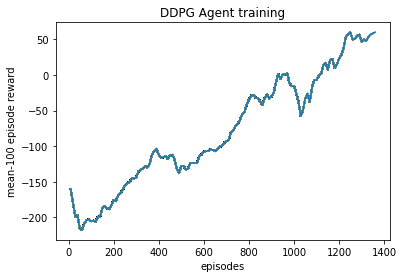

## Training Lunar Lander using DDPG algorithm with Gaussian noise exploration

In [14]:
continue_training = int(input('continue_training..?'))

### finding save dir path...
dir_path =  '/content/drive/MyDrive/RL_implementations/LunarLander_Cont-V2/DDPG'
save_dir_name = find_model_dir_title(dir_path, continue_training)

if(continue_training==0):
  print('Created\t',save_dir_name )
  os.mkdir(save_dir_name)

continue_training..?0
I got  0
Created	 /content/drive/MyDrive/RL_implementations/LunarLander_Cont-V2/DDPG/exp4


In [16]:
### Setup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LL_env = gym.make('LunarLanderContinuous-v2')

DDPG_agent = DDPGAgent(env = LL_env,
                       seed = 0,
                       device = device,
                       BUFFER_SIZE = 50000,
                       BATCH_SIZE = 128,
                       GAMMA = 0.99,
                       ANet_LR = 1e-4 ,
                       CNet_LR = 1e-3,
                       TAU = 0.0001
                       )


if(continue_training==1):
    print("Continue from previous model ...")

    DDPG_agent.CNet.load_state_dict(torch.load(save_dir_name + '/last_CNet.pth'))
    DDPG_agent.CNet_target.load_state_dict(torch.load(save_dir_name + '/last_CNet_target.pth'))

    DDPG_agent.ANet.load_state_dict(torch.load(save_dir_name + '/last_ANet.pth'))
    DDPG_agent.ANet_target.load_state_dict(torch.load(save_dir_name + '/last_ANet_target.pth'))


Enter a comment..gauss
Episode 1	Average Score -111.28
Environment solve in 1 epsiodes!	Average score: -111.28
BEST Created!!
Episode 10	Average Score -326.68
Episode 20	Average Score -290.84
Episode 30	Average Score -222.23
Episode 40	Average Score -212.80
Episode 50	Average Score -192.03
Episode 60	Average Score -185.00
Episode 70	Average Score -223.06
Episode 80	Average Score -235.38
Episode 90	Average Score -240.26
Episode 100	Average Score -254.72
Episode 110	Average Score -250.45
Episode 120	Average Score -252.95
Episode 130	Average Score -269.86
Episode 140	Average Score -268.15
Episode 150	Average Score -280.23
Episode 160	Average Score -285.97
Episode 170	Average Score -264.75
Episode 180	Average Score -250.05
Episode 190	Average Score -244.25
Episode 200	Average Score -224.01
Episode 210	Average Score -222.47
Episode 220	Average Score -213.20
Episode 230	Average Score -205.41
Episode 240	Average Score -212.11
Episode 250	Average Score -205.73
Episode 260	Average Score -205.17

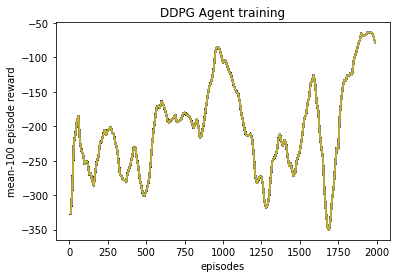

In [18]:
DDPG_agent.train_agent(env = LL_env,
                       save_dir_name = save_dir_name ,
                       n_episodes = 2000,
                       TARGET_SCORE = -600,
                       SCORE_WINDOW_LEN = 100,
                       noise_type = 'GAUSS')

# Observations

For DDPG :              BUFFER_SIZE = 50000,
                       BATCH_SIZE = 128,
                       GAMMA = 0.99,
                       ANet_LR = 1e-4 ,
                       CNet_LR = 1e-3,
                       TAU = 0.0001

# With OU Noise

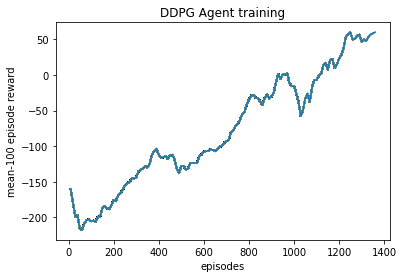

# With gaussian noise

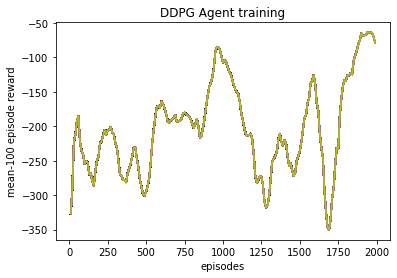

# Observations#

The same can be observed here, the noise with gaussian variant will produce slower learning .